In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, RobustScaler
from sklearn.svm import LinearSVR

import ydata_profiling

from fwi_predict.geo.ee import SENTINEL2_SCL_MAP

ModuleNotFoundError: No module named 'ydata_profiling'

In [673]:
predict_ds = gpd.read_file("../data/clean/ara_predict_ds.geojson")

In [677]:
gfs_forecast['forecast_hours'].value_counts()

forecast_hours
3     12540
9      4692
15     2586
26     1496
29     1245
25     1075
30      678
24      208
28      189
27       71
21       16
33       14
39       13
50        4
60        4
49        3
59        2
Name: count, dtype: int64

Have to understand why we are never getting 21 hours.

You also have to make sure that are always getting the forecast time as the time you are interested.

In [679]:
gfs_forecast.groupby('sample_idx')['forecast_hours'].last().value_counts() # Show measurement forecast hour.

forecast_hours
26    1496
29    1245
25    1075
30     678
24     208
28     189
27      57
15       7
50       4
60       4
49       3
59       2
33       1
Name: count, dtype: int64

The seven that have 15 are some kind of error, but everything else is at least 24 hours. Also remember that these times are not tz localized.

Start with dissolved oxygen

In [687]:
y_var = 'ph'
y = predict_df[y_var] # Later maybe use specific hour rather than morning/evening time of day
X = predict_df[['morning', 'property_area_acres', 'pond_depth_meters'] + gfs_wide.columns.tolist()]
nan_idx = (y.isna() | X.apply(lambda x: x.isna().any(), axis=1))
X, y = X[~nan_idx], y[~nan_idx]

### Pairplot of outcome against inputs

Next steps
- Look for spatial and other correlations to stratify by in test/train split
- Look at the distance in time between samples at same pond
- Investigate most important features
- Explore performance across distribution
- Test different models/pruning
- Test farther forecasting

We're going to start by doing a stratified group split into test/train, then a stratified Kfold. We group by Farm ID and stratify by bins of the outcome variable. This will help ensure some class balance.

1.0    1328
3.0    1270
2.0    1180
0.0    1090
Name: count, dtype: int64


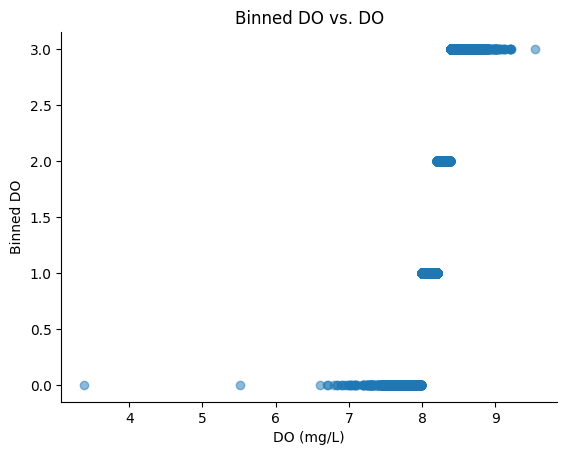

In [690]:
# Discretize outcome variable
y_bin_est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
y_bin_est.fit(y.to_numpy().reshape(-1, 1))
y_binned = y_bin_est.transform(y.to_numpy().reshape(-1, 1))

# Plot result from binning with actual values also represented
fig, ax = plt.subplots()
ax.scatter(y, y_binned, alpha=0.5)
ax.set_xlabel('DO (mg/L)')
ax.set_ylabel('Binned DO')
ax.set_title('Binned DO vs. DO')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(pd.Series(y_binned.flatten()).value_counts())

I'm going to do four bins for now, but something to think about.

There is this severe outlier. Make sure to write to Jennifer about.

In [691]:
test_train_splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(test_train_splitter.split(X, y_binned, groups=split_groups))
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
groups_train, groups_test = split_groups[train_idx], split_groups[test_idx]
print(f"Test set share: {100 * test_idx.shape[0] / (train_idx.shape[0] + test_idx[0]):.2f}%")

Test set share: 24.82%


Not exactly 20% because we are doing stratified group split.

In [692]:
model = Pipeline([
  ('scale,', StandardScaler()),
  ('regress', RandomForestRegressor())
])
model

Pipeline(steps=[('scale,', StandardScaler()),
                ('regress', RandomForestRegressor())])

In [693]:
import itertools

from joblib import Parallel, delayed, cpu_count
from sklearn.utils import resample, shuffle
from sklearn.model_selection import GroupKFold, RepeatedKFold
from tqdm import tqdm

In [694]:
CV_LOOPS = 5
FOLDS = 10
rng = np.random.default_rng(42)
shuffle_seeds = rng.integers(0, 2**32, size=CV_LOOPS)
cv_splitter = GroupKFold(n_splits=FOLDS)
results_list = []

def run_cv_split(seed):
  """Run cross-validation loop."""
  cv_results = [] # Need to figure out how to do this.
  shuffle_idx = shuffle(np.arange(len(X)), random_state=seed) 
  folds = list(cv_splitter.split(shuffle_idx, groups=split_groups[shuffle_idx]))

  for fold_idx, (train_idx, test_idx) in enumerate(folds):
    train_idx, test_idx = shuffle_idx[train_idx], shuffle_idx[test_idx]
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_test_fold, y_test_fold = X.iloc[test_idx], y.iloc[test_idx]
    model.fit(X_train_fold.to_numpy(), y_train_fold.to_numpy().flatten())
    y_pred = model.predict(X_test_fold.to_numpy())
    cv_results.append({
      'split_idx': fold_idx,
      'train_idx': train_idx,
      'test_idx': test_idx,
      'y_pred': y_pred,
      'model': model,
      'mae': np.mean(np.abs(y_pred - y_test_fold)),
      'mse': np.mean((y_pred - y_test_fold) ** 2),
      'r2': model.score(X_test_fold, y_test_fold)
    })
  
  # Flatten lists
  return cv_results

num_cores = cpu_count() - 1
results_list = Parallel(n_jobs=num_cores)(delayed(run_cv_split)(seed) for seed in tqdm(shuffle_seeds))

100%|██████████| 5/5 [00:00<00:00, 3129.61it/s]


Check that this parallel method preserves correct list order

In [695]:
results_list_flat = list(itertools.chain.from_iterable(results_list))

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


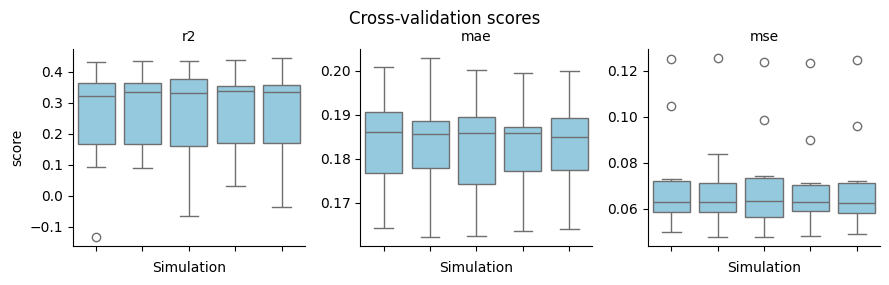

In [696]:
def plot_scores(results_list):
  """Plot scores from cross-validation results."""
  # Pull scores into a df
  scores = pd.DataFrame([
    {
      'sim_idx': i // FOLDS,
      'split_idx': res['split_idx'],
      'r2': res['r2'],
      'mae': res['mae'],
      'mse': res['mse']
    }
    for i, res in enumerate(results_list)
  ])
  scores = scores.melt(
    id_vars=['sim_idx', 'split_idx'],
    value_vars=['r2', 'mae', 'mse'],
    var_name='metric',
    value_name='score'
  )

  # Plot scores
  
  g = sns.FacetGrid(scores, col='metric', sharey=False)
  g.map(sns.boxplot, 'sim_idx', 'score', color='skyblue')
  g.set_titles('{col_name}')
  g.set_xlabels('Simulation')
  g.fig.suptitle('Cross-validation scores')
  g.fig.tight_layout()
  g.fig.subplots_adjust(top=0.85)

  # Remove xtick labels
  for ax in g.axes.flat:
    ax.set_xticklabels([])

  return g

plot_scores(results_list_flat)

Plot the distribution of scores

That's clarifying. We're generally getting performances around 0.7 R^2, but there is always one or two outliers. You should check what points they correspond to.

In [697]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import LearningCurveDisplay, ValidationCurveDisplay

In [698]:
predictions_df = [
  pd.DataFrame.from_dict({
    'sim_idx': [i // FOLDS] * len(res['test_idx']),
    'split_idx': [res['split_idx']] * len(res['test_idx']),
    'idx': res['test_idx'].tolist(),
    'y_true': y.iloc[res['test_idx']].tolist(),
    'y_pred': res['y_pred'].tolist()
  }) for i, res in enumerate(results_list_flat)
]

predictions_df = pd.concat(predictions_df, ignore_index=True)


In [699]:
def remove_box(ax: plt.Axes) -> plt.Axes:
  """Remove box around plot."""
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  return ax

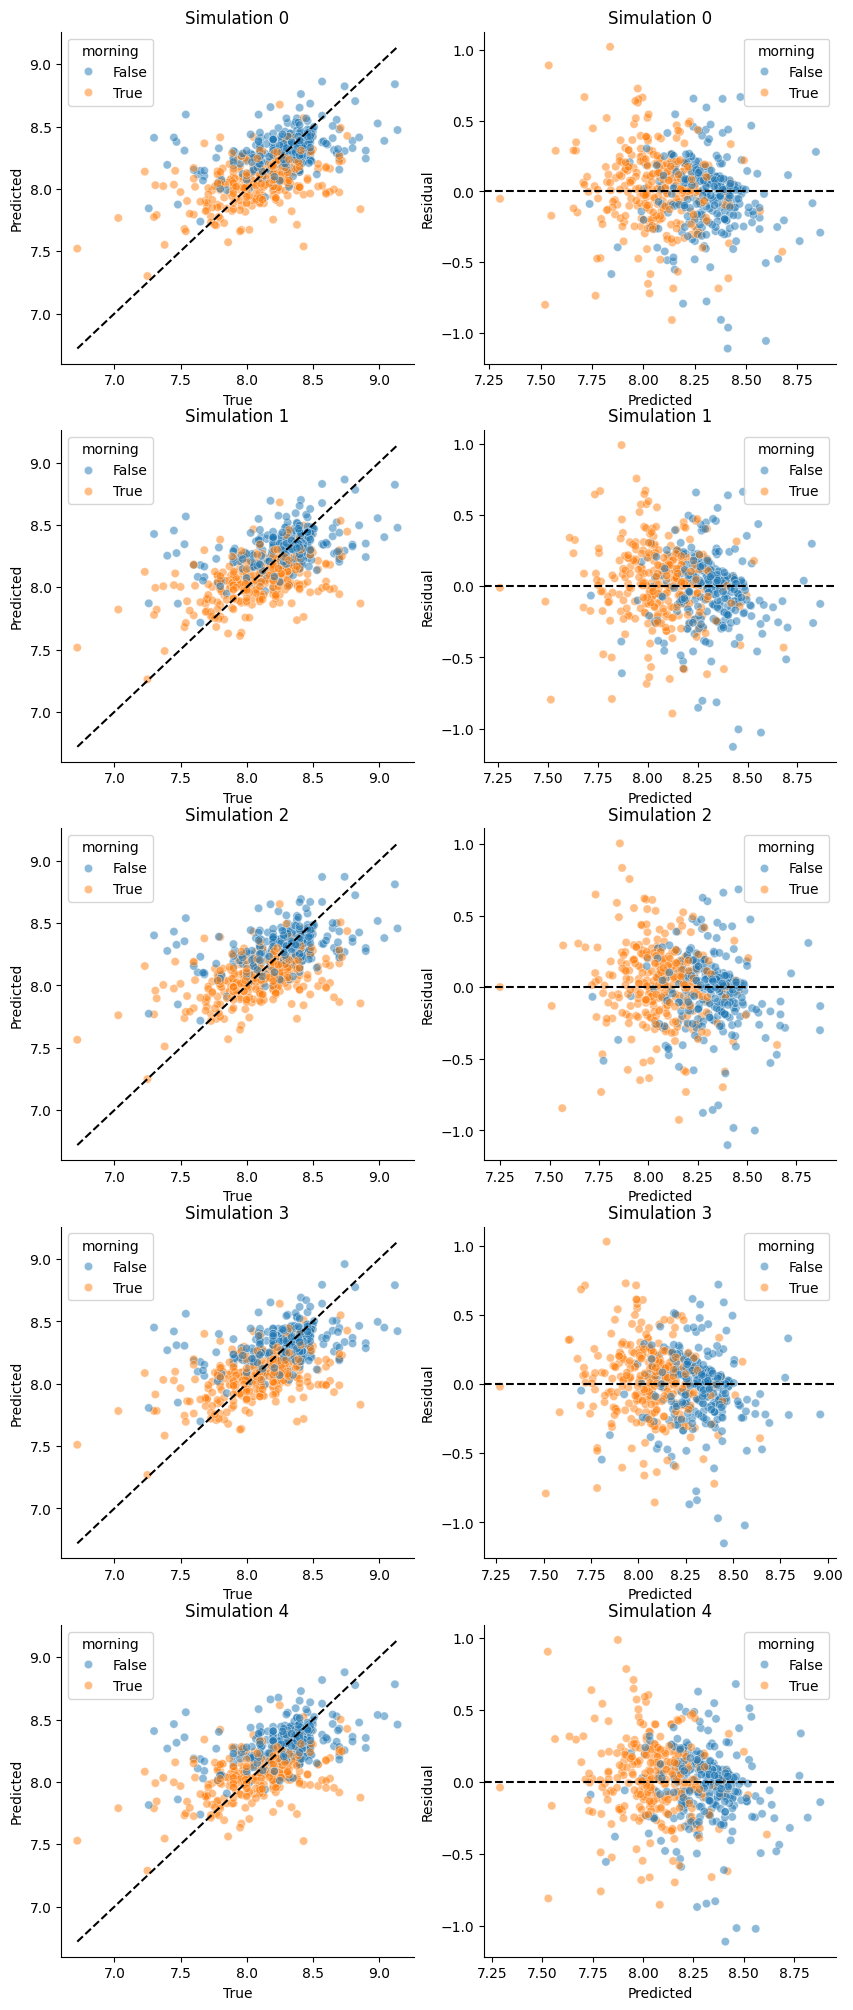

In [700]:
fig, axs = plt.subplots(CV_LOOPS, 2, figsize=(10, 5 * CV_LOOPS))

predictions_df['morning'] = predictions_df['idx'].map(lambda i: X.iloc[i]['morning'])
predictions_df['residual'] = predictions_df['y_true'] - predictions_df['y_pred']

rng = np.random.default_rng(42)
sample_idx = rng.choice(np.arange(len(X)), 600, replace=False)

for i in range(CV_LOOPS):
  # Plot predictions
  plot_sample = predictions_df[(predictions_df['sim_idx'] == i) & 
                               predictions_df['idx'].isin(sample_idx)
                               ]
  
  min = plot_sample[['y_true', 'y_pred']].min().min()
  max = plot_sample[['y_true', 'y_pred']].max().max()

  # Plot predictions against true values
  ax = axs[i, 0]
  sns.scatterplot(data=plot_sample,
                  x='y_true',
                  y='y_pred',
                  hue='morning',
                  alpha=0.5,
                  ax=ax)
  ax.plot([min, max], [min, max], color='black', linestyle='--')
  ax.set_xlabel('True')
  ax.set_ylabel('Predicted')
  ax.set_title(f'Simulation {i}')
  ax = remove_box(ax)

  # Plot residuals
  ax = axs[i, 1]
  sns.scatterplot(data=plot_sample,
                  x='y_pred',
                  y='residual',
                  hue='morning',
                  alpha=0.5,
                  ax=ax)
  ax.axhline(0, color='black', linestyle='--')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Residual')
  ax.set_title(f'Simulation {i}')
  ax = remove_box(ax)



- Note that figures above are taking a subsample of test values and predictions. They do not show all of the test set data points.
- The model is fitting very well to the difference between morning and evening samples, but the correlation after that between predicted and true values does not appear that strong.

### Feature permutation importance

In [701]:
# Characterize feature permutation importance
model = results_list_flat[0]['model']
X_test = X.iloc[results_list_flat[0]['test_idx']].to_numpy()
y_test = y.iloc[results_list_flat[0]['test_idx']].to_numpy().flatten()
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, scoring='r2')

C:\Users\squaade\AppData\Local\Temp\ipykernel_28296\3271901113.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])


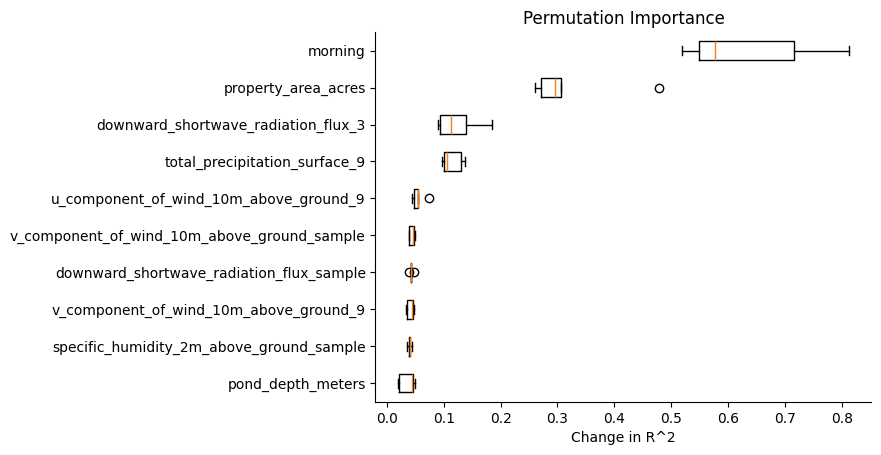

In [702]:
# Plot permutation importance
fig, ax = plt.subplots()
sorted_idx = perm_importance.importances_mean.argsort()[::-1][0:10][::-1]
ax.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title('Permutation Importance')
ax.set_xlabel('Change in R^2')
ax = remove_box(ax)

Time of day is doing all of the heavy lifting.

I think you want to explore how good you are at predicting whether things are out of range.

In [703]:
from fwi_predict.wq import check_in_range
predictions_df['time_of_day'] = predictions_df['morning'].map(lambda x: 'morning' if x else 'evening')
predictions_df['true_in_range'] = check_in_range(parameter=y_var,
                                                 values=predictions_df['y_true'],
                                                 periods=predictions_df['time_of_day'])
predictions_df['pred_in_range'] = check_in_range(parameter=y_var,
                                                  values=predictions_df['y_pred'],
                                                  periods=predictions_df['time_of_day'])

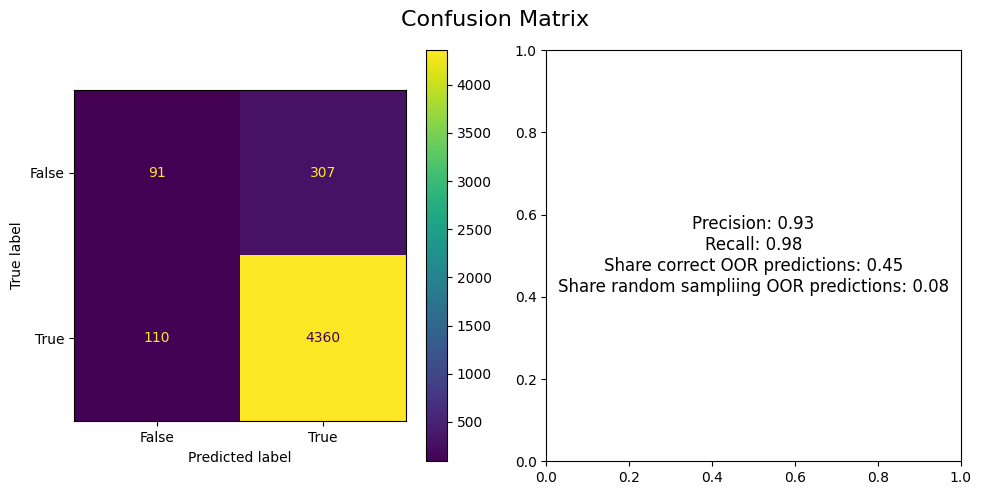

In [704]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from textwrap import dedent

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

temp = predictions_df[predictions_df['sim_idx'] == 0]

ConfusionMatrixDisplay.from_predictions(temp['true_in_range'], temp['pred_in_range'], ax=axs[0])

precision = precision_score(temp['true_in_range'], temp['pred_in_range'])
recall = recall_score(temp['true_in_range'], temp['pred_in_range'])
pred_oor = temp[~temp['pred_in_range']]
share_false_correct = np.mean(pred_oor['true_in_range'] == pred_oor['pred_in_range'])
random_sample_OOR = np.mean(~temp['true_in_range'])

axs[1].text(0.5,
            0.5, 
            (f"Precision: {precision:.2f}\n"
             f"Recall: {recall:.2f}\n"
             f"Share correct OOR predictions: {share_false_correct:.2f}\n"
             f"Share random sampliing OOR predictions: {random_sample_OOR:.2f}"),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=12,
            transform=axs[1].transAxes)

fig.tight_layout()
fig.suptitle('Confusion Matrix', fontsize=16)
fig.subplots_adjust(top=0.9)

In [705]:
y_var = 'ph_in_req_range'
y = predict_df[y_var].apply(lambda x: True if x == 'True' else False).astype(bool) # Later maybe use specific hour rather than morning/evening time of day
X = predict_df[['morning', 'property_area_acres', 'pond_depth_meters'] + gfs_wide.columns.tolist()]
nan_idx = (predict_df[y_var].isna()) | (predict_df[y_var] == None) | (X.apply(lambda x: x.isna().any(), axis=1))
X, y = X[~nan_idx], y[~nan_idx]

In [706]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([
  ('scale,', StandardScaler()),
  ('classify', RandomForestClassifier())
])
model

Pipeline(steps=[('scale,', StandardScaler()),
                ('classify', RandomForestClassifier())])

In [707]:
from sklearn.model_selection import KFold

CV_LOOPS = 5
FOLDS = 10
rng = np.random.default_rng(42)
shuffle_seeds = rng.integers(0, 2**32, size=CV_LOOPS)
cv_splitter = KFold(n_splits=FOLDS)
results_list = []

def run_cv_split(seed):
  """Run cross-validation loop."""
  cv_results = [] # Need to figure out how to do this.
  shuffle_idx = shuffle(np.arange(len(X)), random_state=seed) 
  folds = list(cv_splitter.split(shuffle_idx))

  for fold_idx, (train_idx, test_idx) in enumerate(folds):
    train_idx, test_idx = shuffle_idx[train_idx], shuffle_idx[test_idx]
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = y_prob > 0.5
    cv_results.append({
      'split_idx': fold_idx,
      'train_idx': train_idx,
      'test_idx': test_idx,
      'model': model,
      'y_prob': y_prob,
      'y_pred': y_pred,
      'precision': precision_score(y_test, y_pred),
      'recall': recall_score(y_test, y_pred),
    })
  
  # Flatten lists
  return cv_results

num_cores = cpu_count() - 1
results_list = Parallel(n_jobs=num_cores)(delayed(run_cv_split)(seed) for seed in tqdm(shuffle_seeds))

100%|██████████| 5/5 [00:00<00:00, 3633.32it/s]


In [708]:
results_list_flat = list(itertools.chain.from_iterable(results_list))

In [709]:
predictions_df = [
  pd.DataFrame.from_dict({
    'sim_idx': [i // FOLDS] * len(res['test_idx']),
    'split_idx': [res['split_idx']] * len(res['test_idx']),
    'idx': res['test_idx'].tolist(),
    'y_true': y.iloc[res['test_idx']].tolist(),
    'y_pred': res['y_pred'].tolist(),
    'y_prob': res['y_prob'].tolist()
  }) for i, res in enumerate(results_list_flat)
]

predictions_df = pd.concat(predictions_df, ignore_index=True)

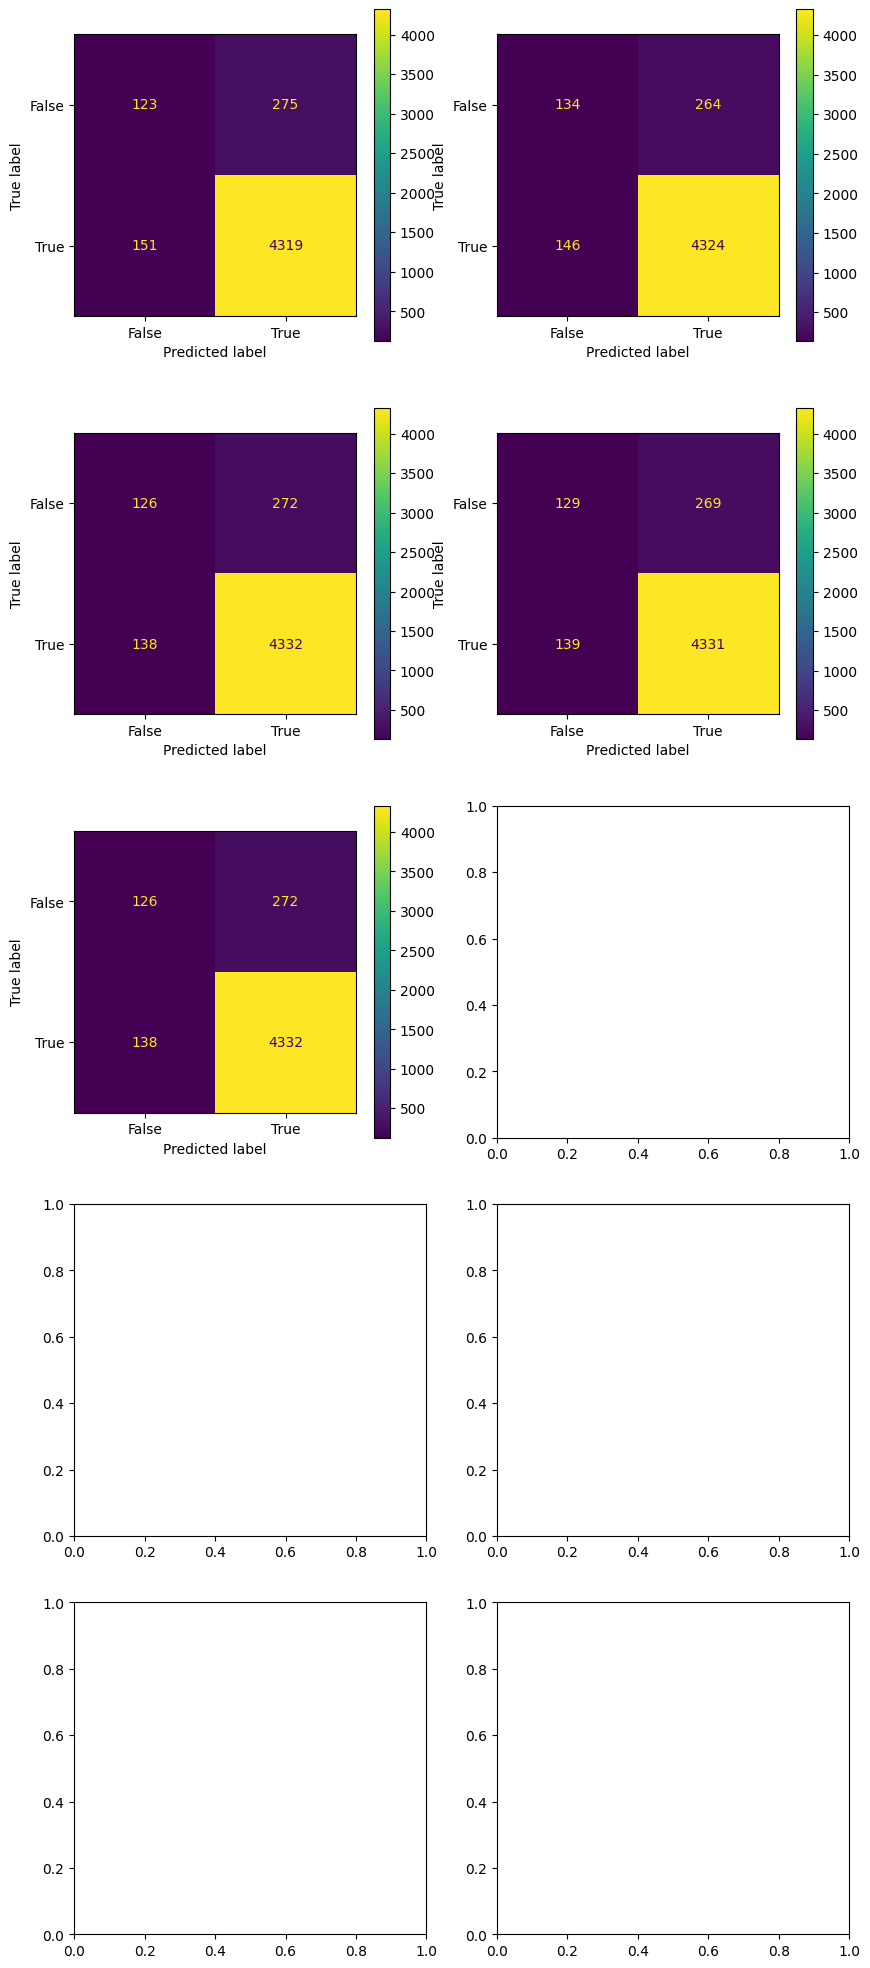

In [710]:
# Generate confusion matrix for each fold

fig, axs = plt.subplots(CV_LOOPS, 2, figsize=(10, 5 * CV_LOOPS))

for i in range(CV_LOOPS):
  y_true = predictions_df[predictions_df['sim_idx'] == i]['y_true']
  y_pred = predictions_df[predictions_df['sim_idx'] == i]['y_pred']
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=axs[i//2, i%2])

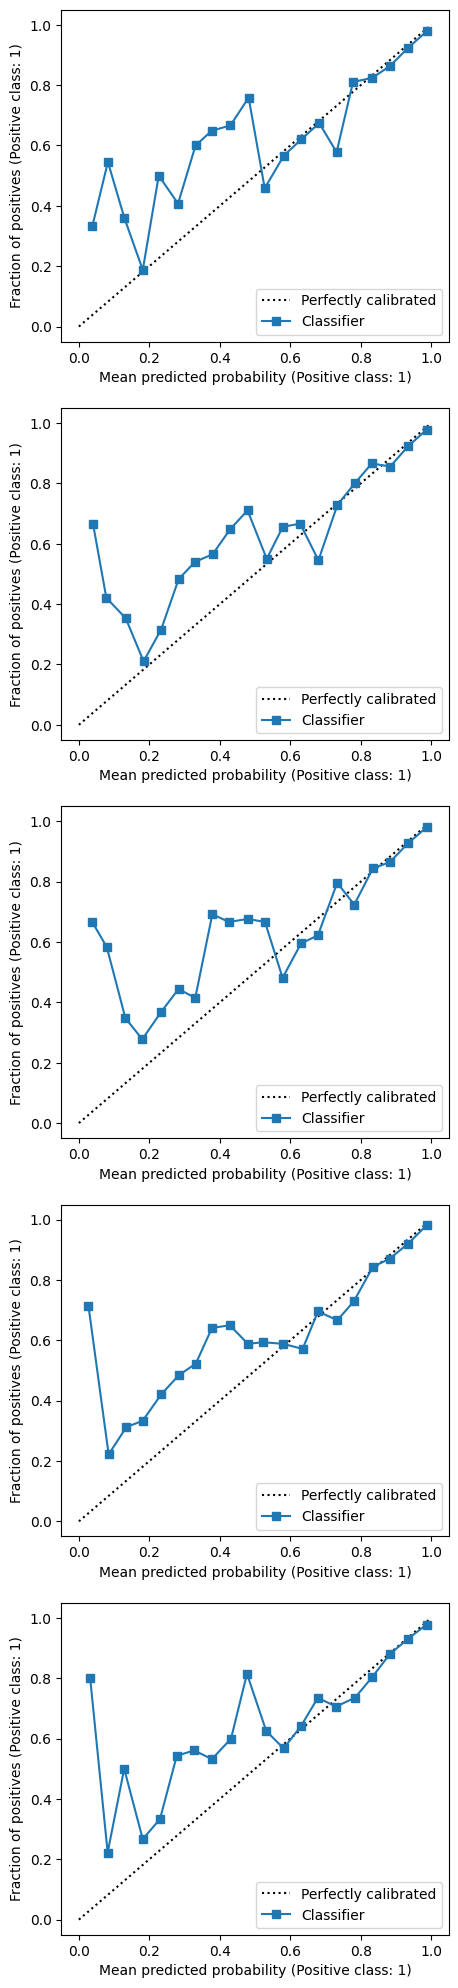

In [711]:
from sklearn.calibration import CalibrationDisplay

fig, axs = plt.subplots(CV_LOOPS, 1, figsize=(5, 5 * CV_LOOPS))

for i in range(CV_LOOPS):
  y_true = predictions_df[predictions_df['sim_idx'] == i]['y_true']
  y_prob = predictions_df[predictions_df['sim_idx'] == i]['y_prob']
  CalibrationDisplay.from_predictions(y_true, y_prob, ax=axs[i], n_bins=20)

<Axes: title={'center': 'Calibration Plot'}, xlabel='Mean predicted probability (Positive class: 1)', ylabel='Fraction of positives (Positive class: 1)'>

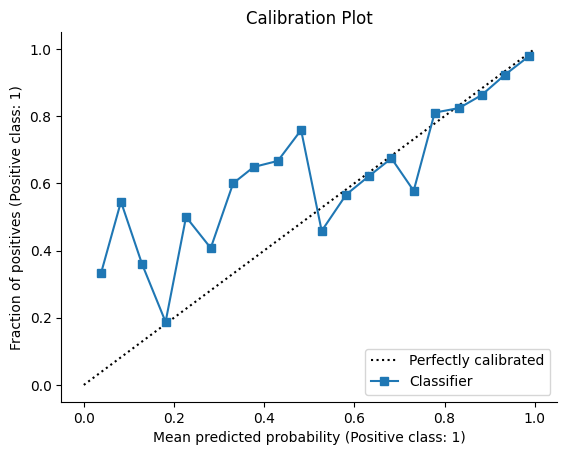

In [712]:
# Show first calibration plot
# Add title and remove spines

fig, ax = plt.subplots()

CalibrationDisplay.from_predictions(predictions_df[predictions_df['sim_idx'] == 0]['y_true'],
                                    predictions_df[predictions_df['sim_idx'] == 0]['y_prob'],
                                    n_bins=20,
                                    ax=ax)

ax.set_title('Calibration Plot')
remove_box(ax)


Characterize boxplot of performance for each pond. Split them up if you need.